In [ ]:
# !pip install torch datasets transformers numpy pandas scipy matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json
import time
import random
import os
from joblib import Parallel, delayed
import multiprocessing

In [2]:
device = 'cpu'

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
multiprocessing.set_start_method("spawn", force=True)

In [5]:
# torch.cuda.empty_cache()

In [6]:


# if torch.cuda.is_available():
#     print("CUDA is available!")
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available. Running on CPU.")
#     device = torch.device("cpu")

In [ ]:
# load a wikipedia dataset
dataset = load_dataset("tcltcl/inuit-and-truncated-american-wikipedia", trust_remote_code=True)


In [8]:
# load a small pretrained GPT model and tokenizer
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# use the eos token as padding
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
max_length = 1024  # model's max length
stride = 512  # set stride between overlapping chunks of text tokens
context_buffer = 32  # number of tokens from left-side context each chunk
chunked_tokens = []  # tokenized chunks
center_positions = []  # central part of each chunk
# model config token padding
model.config.pad_token_id = tokenizer.pad_token_id
max_input_length = model.config.n_positions  # 1024 for distilgpt2
# tokenize data to have consistent sequence length
for item in dataset["train"]:
    # get text
    text = item["text"]
    # tokenize as 1D list (no batches)
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"].squeeze(0)
    token_length = len(tokens)

    # make overlapping sliding window chunks of text
    for i in range(0, token_length, stride):
        # include left context in window, but stay in bounds
        start = max(i - context_buffer, 0)
        end = min(start + max_input_length, token_length)  # end of chunk, within max

        token_chunk = tokens[start:end]  # get chunk slice

        # double check no chunk exceeds model limit
        assert len(token_chunk) <= max_input_length, f"chunk too long: {len(token_chunk)}"

        chunked_tokens.append(token_chunk)
        center_start = i - start  # get center tokens in chunk
        center_end = min(center_start + stride, len(token_chunk))
        center_positions.append((center_start, center_end))


Token indices sequence length is longer than the specified maximum sequence length for this model (3721 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
tokenizer('inuit')

{'input_ids': [259, 5013], 'attention_mask': [1, 1]}

In [11]:
tokenizer.decode([259])

'in'

In [12]:
tokenizer.decode([5013])

'uit'

In [13]:
tokenizer('american')

{'input_ids': [2382, 7490], 'attention_mask': [1, 1]}

In [14]:
tokenizer.decode([2382])

'amer'

In [15]:
tokenizer.decode([7490])

'ican'

In [16]:
tokenizer('ced')

{'input_ids': [771], 'attention_mask': [1]}

In [17]:
tokenizer.decode([771])

'ced'

In [18]:
# get LLM hidden activations
def get_activations(tokenized_inputs, model, layer_idx=0, batch_size=16):
    all_activations = []
    for i in range(0, len(tokenized_inputs), batch_size):
        batch_tokens = tokenized_inputs[i:i+batch_size]
        # pad sequences
        batch_tokens = torch.nn.utils.rnn.pad_sequence(
            batch_tokens, batch_first=True, padding_value=tokenizer.pad_token_id
        )
        batch_tokens = batch_tokens.to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=batch_tokens, output_hidden_states=True)
        act = outputs.hidden_states[layer_idx].cpu()  # get layer activations
        all_activations.append(act)
        # torch.cuda.empty_cache()
    return torch.cat(all_activations, dim=0)  # concat along sequence axis


In [19]:
# get middle layer activations
activations = get_activations(chunked_tokens, model, layer_idx=2)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [ ]:
# set seeds for reproducibility
seed = 42
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)

# if using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
# top k sparse autoencoder
# k determines number of latent activations to keep
class TopKSparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, k):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.k = k

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        # select the top k activations
        topk_values, topk_indices = torch.topk(encoded, self.k, dim=-1)
        # mask where only top k values are 1, in the last dimension
        mask = torch.zeros_like(encoded).scatter_(-1, topk_indices, 1)
        # zero non top k activations
        sparse_encoded = encoded * mask
        decoded = self.decoder(sparse_encoded)
        return decoded, sparse_encoded


In [ ]:
# train SAE
input_dim = activations.shape[-1]  # layer activations size
expansion_factor = 4  # expand activations by this multiple
hidden_dim = input_dim * expansion_factor
k = 32  # top k activations to keep
sae = TopKSparseAutoencoder(input_dim, hidden_dim, k).to(device)
# update sae parameters
optimizer = optim.Adam(sae.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train_sae(sae, activations, epochs=200):
    activations = activations.to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, encoded = sae(activations)
        loss = criterion(decoded, activations)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

train_sae(sae, activations)

Epoch 0: Loss = 75.1775
Epoch 10: Loss = 68.0722
Epoch 20: Loss = 61.3054
Epoch 30: Loss = 52.9919
Epoch 40: Loss = 43.2390
Epoch 50: Loss = 32.1089
Epoch 60: Loss = 21.5313
Epoch 70: Loss = 13.1934
Epoch 80: Loss = 8.2305
Epoch 90: Loss = 6.1567
Epoch 100: Loss = 5.2990
Epoch 110: Loss = 4.5726
Epoch 120: Loss = 3.8434
Epoch 130: Loss = 3.2508
Epoch 140: Loss = 2.7674
Epoch 150: Loss = 2.3784
Epoch 160: Loss = 2.0247
Epoch 170: Loss = 1.7300
Epoch 180: Loss = 1.4882
Epoch 190: Loss = 1.2859


In [23]:
"""
Epoch 0: Loss = 75.1775
Epoch 10: Loss = 68.0722
Epoch 20: Loss = 61.3054
Epoch 30: Loss = 52.9919
Epoch 40: Loss = 43.2390
Epoch 50: Loss = 32.1089
Epoch 60: Loss = 21.5313
Epoch 70: Loss = 13.1934
Epoch 80: Loss = 8.2305
Epoch 90: Loss = 6.1567
Epoch 100: Loss = 5.2990
Epoch 110: Loss = 4.5726
Epoch 120: Loss = 3.8434
Epoch 130: Loss = 3.2508
Epoch 140: Loss = 2.7674
Epoch 150: Loss = 2.3784
Epoch 160: Loss = 2.0247
Epoch 170: Loss = 1.7300
Epoch 180: Loss = 1.4882
Epoch 190: Loss = 1.2859
"""

'\nEpoch 0: Loss = 75.1775\nEpoch 10: Loss = 68.0722\nEpoch 20: Loss = 61.3054\nEpoch 30: Loss = 52.9919\nEpoch 40: Loss = 43.2390\nEpoch 50: Loss = 32.1089\nEpoch 60: Loss = 21.5313\nEpoch 70: Loss = 13.1934\nEpoch 80: Loss = 8.2305\nEpoch 90: Loss = 6.1567\nEpoch 100: Loss = 5.2990\nEpoch 110: Loss = 4.5726\nEpoch 120: Loss = 3.8434\nEpoch 130: Loss = 3.2508\nEpoch 140: Loss = 2.7674\nEpoch 150: Loss = 2.3784\nEpoch 160: Loss = 2.0247\nEpoch 170: Loss = 1.7300\nEpoch 180: Loss = 1.4882\nEpoch 190: Loss = 1.2859\n'

In [ ]:
# use trained SAE to get activation values
sae.eval()
with torch.no_grad():
    _, sparse_encoded = sae(activations)


In [ ]:
# save npz file with tokens and SAE activations
np.savez_compressed("feature_activations_combo.npz",
                    tokens=np.array([tokens.tolist() for tokens in chunked_tokens], dtype=object),
                    features=sparse_encoded.cpu().numpy(),
                    center_positions=np.array(center_positions, dtype=object))

In [26]:
# check activation values for a certain feature
data = np.load("feature_activations_combo.npz", allow_pickle=True)
feature_activations = data["features"]  # shape: (136, 1024, 3072)

print(f"Feature 0 activation values: {feature_activations[:, :, 0].flatten()[:20]}")


Feature 0 activation values: [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  9.26479    0.         0.         0.         0.         0.
  0.        11.7279415]


In [27]:
# get activation info
print(f"Max activation: {sparse_encoded.max().item()}")
print(f"Min activation: {sparse_encoded.min().item()}")
print(f"Mean activation: {sparse_encoded.mean().item()}")
print(f"Nonzero activations count: {(sparse_encoded != 0).sum().item()}")
print(f"Zero activations count:  {(sparse_encoded == 0).sum().item()}")

Max activation: 464.63458251953125
Min activation: 0.0
Mean activation: 0.287124902009964
Nonzero activations count: 4456448
Zero activations count:  423362560


In [28]:
# check file size (though file could be checked in explorer)

file_size = os.path.getsize("feature_activations_combo.npz") / (1024**2)  # MB
print(f"Feature activations file size: {file_size:.2f} MB")


Feature activations file size: 27.87 MB


In [29]:
print(f"SAE output shape: {sparse_encoded.shape}")  # Should be (batch, 1024, 3072)


SAE output shape: torch.Size([136, 1024, 3072])


In [30]:
sparse_encoded.shape

torch.Size([136, 1024, 3072])

In [31]:
activations.shape

torch.Size([136, 1024, 768])

In [ ]:
# get mean top activations from words per feature
startt = time.perf_counter()

def process_entire_dataset_word(filename, tokenizer, feature_idx, top_n=10):
    data = np.load(filename, allow_pickle=True)
    tokens_list = data["tokens"]
    feature_activations = data["features"]

    word_activation_strength = {}
    word_counts = {}
    # monitor time (longest process in notebook, could be few hours)
    print('Feature', feature_idx, 'Shape:', feature_activations.shape, time.perf_counter() - startt)
    # check if all values in a latent are 0 and set all to ("@@@@", 0.0) if so
    if np.all(feature_activations[:, :, feature_idx] == 0):
        return [("@@@@", 0.0)] * top_n
    # loop through tokens and feature activations
    for tokens, activations in zip(tokens_list, feature_activations):
        tokens = torch.tensor(tokens, dtype=torch.long)
        # get activatoins for the feature
        activations = torch.tensor(activations, dtype=torch.float32)[:, feature_idx]
        # convert tokens to words
        token_list = tokenizer.convert_ids_to_tokens(tokens.tolist())

        reconstructed_words = []
        current_word = ""
        current_activations = []
        # loop through each token and its activations
        for token, activation in zip(token_list, activations.tolist()):
            # check if token continues a previous word
            if token.startswith("##") or (current_word and not token.startswith("Ġ")):
                # append token to current word without ## if token starts with that
                current_word += token[2:] if token.startswith("##") else token
                current_activations.append(activation)
            else:
                # if word is complete append it
                if current_word:
                    reconstructed_words.append((current_word, current_activations))
                # start new current word, without G symbol that may indicate new word
                current_word = token.lstrip("Ġ")
                current_activations = [activation]
        # append last word if there
        if current_word:
            reconstructed_words.append((current_word, current_activations))
        # get mean activation per word
        for word, activations in reconstructed_words:
            avg_activation = sum(activations) / len(activations)
            # add word if not seen before
            if word not in word_activation_strength:
                word_activation_strength[word] = 0
                word_counts[word] = 0
            # add activations
            word_activation_strength[word] += avg_activation
            word_counts[word] += 1
    # get mean activation per word across data
    avg_word_activations = {word: word_activation_strength[word] / word_counts[word]
                            for word in word_activation_strength}
    # sort words by mean activation, descending
    sorted_words = sorted(avg_word_activations.items(), key=lambda item: item[1], reverse=True)
    # get the top n words with highest activations
    top_words = [(word, avg_word_activations[word]) for word, _ in sorted_words[:top_n]]

    return top_words


In [ ]:
# get mean top activations from words per feature
startt = time.perf_counter()
def process_entire_dataset_word(filename, tokenizer, feature_idx, top_n=10):

    data = np.load(filename, allow_pickle=True)
    tokens_list = data["tokens"]
    feature_activations = data["features"]
    center_positions = data["center_positions"]

    word_activation_strength = {}  # activation sums
    word_counts = {}
    # monitor time
    print('Feature', feature_idx, 'Shape:', feature_activations.shape, time.perf_counter() - startt)

    # check if all values in a latent are 0 and set all to ("@@@@", 0.0) if so
    if np.all(feature_activations[:, :, feature_idx] == 0):
        return [("@@@@", 0.0)] * top_n

    # Loop through tokens and feature activations
    for tokens, activations in zip(tokens_list, feature_activations):
        tokens = torch.tensor(tokens, dtype=torch.long)
        activations = torch.tensor(activations, dtype=torch.float32)[:, feature_idx]  # get activations for the feature

        # convert tokens to words
        token_list = tokenizer.convert_ids_to_tokens(tokens.tolist())

        reconstructed_words = []
        current_word = ""
        current_activations = []
        score_fn = "mean"

        for token, activation in zip(token_list, activations):
            # continuation of current word (with or without '##')
            if token.startswith("##") or (current_word and not token.startswith("Ġ")):
                clean_token = token[2:] if token.startswith("##") else token
                current_word += clean_token
                current_activations.append(activation)
            else:
                # Attach 'uit' to previous word if part of a larger word like 'Inuit'
                if token == 'uit' and current_word:
                    current_word += token
                    current_activations.append(activation)
                else:
                    # new word starting
                    if current_word:
                        # compute activation score
                        score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
                        reconstructed_words.append((current_word, score))
                    current_word = token.lstrip("Ġ")  # remove GPT token prefix
                    current_activations = [activation]

        # catch last word
        if current_word:
            score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
            reconstructed_words.append((current_word, score))

        # get mean activation per word
        for word, score in reconstructed_words:
            if len(word) < 2 or not word.isascii():  # Skip short or non-ASCII words
                continue
            # add word if not seen before
            if word not in word_activation_strength:
                word_activation_strength[word] = 0
                word_counts[word] = 0
            # add activations
            word_activation_strength[word] += score
            word_counts[word] += 1

    # get mean activation per word across data
    avg_word_activations = {word: float(word_activation_strength[word] / word_counts[word])
                            for word in word_activation_strength}
    # sort words by mean activation, descending
    sorted_words = sorted(avg_word_activations.items(), key=lambda item: item[1], reverse=True)
    return sorted_words[:top_n]  # get the top n words with highest activations


In [ ]:
# number of features in the sparse autoencoder
num_features = hidden_dim

start_time = time.perf_counter()

# run in parallel across CPU cores
top_word_feat = Parallel(n_jobs=8)(
    delayed(process_entire_dataset_word)("feature_activations_combo.npz", tokenizer, feature_idx, top_n=20)
    for feature_idx in range(num_features)
)

# convert to dict (Parallel returns a list)
top_word_feat_dict = {feature_idx: top_word_feat[feature_idx] for feature_idx in range(num_features)}

end_time = time.perf_counter()
print(f"Processing completed in {end_time - start_time:.2f} seconds")


Feature 3 Shape: (136, 1024, 3072) 55.629382846003864
Feature 14 Shape: (136, 1024, 3072) 60.050766430969816
Feature 22 Shape: (136, 1024, 3072) 64.39445723599056
Feature 29 Shape: (136, 1024, 3072) 67.4805782379699
Feature 38 Shape: (136, 1024, 3072) 71.43246993696084
Feature 45 Shape: (136, 1024, 3072) 74.39409187895944
Feature 51 Shape: (136, 1024, 3072) 77.33934905595379
Feature 60 Shape: (136, 1024, 3072) 81.25066892796895
Feature 68 Shape: (136, 1024, 3072) 85.22391801397316
Feature 76 Shape: (136, 1024, 3072) 88.10083542298526
Feature 84 Shape: (136, 1024, 3072) 92.01161888497882
Feature 89 Shape: (136, 1024, 3072) 94.87688922899542
Feature 99 Shape: (136, 1024, 3072) 98.81173659098567
Feature 105 Shape: (136, 1024, 3072) 101.67411143396748
Feature 114 Shape: (136, 1024, 3072) 105.84097459795885
Feature 122 Shape: (136, 1024, 3072) 110.00227262999397
Feature 131 Shape: (136, 1024, 3072) 114.16185021097772
Feature 140 Shape: (136, 1024, 3072) 118.14909517299384
Feature 147 Shape:

In [34]:
# dict of non dead latents, and 0 values paired with '@@@@' filler
top_word_clean = {}
for k, v in top_word_feat_dict.items():
    if v[0][0] == '@@@@':
        continue
    for i, fv in enumerate(v):
        if fv[1] == 0.0:
            v[i] = ('@@@@', 0.0)
    top_word_clean[k] = v
    print('feature', k, v, '\n')

feature 0 [('South', 17.618019104003906), ('Fair', 17.498449325561523), ('Camp', 17.018775939941406), ('St', 16.910795211791992), ('Allies', 16.397016525268555), ('First', 16.231245040893555), ('Japanese', 15.947101593017578), ('Ku', 15.689803123474121), ('Jim', 15.503690719604492), ('natives', 15.484280586242676), ('Montgomery', 15.440364837646484), ('Dutch', 15.347058296203613), ('18th', 15.337347030639648), ('Missouri', 15.28809642791748), ('North', 14.931998252868652), ('Birmingham', 14.471944808959961), ('Patriot', 14.365835189819336), ('geology', 14.085803985595703), ('Confederate', 13.813265800476074), ('1880s', 13.767179489135742)] 

feature 3 [('US', 13.409342765808105), ('Missouri', 10.23753833770752), ('AD', 9.898506164550781), ('Virginia', 9.431769371032715), ('States', 9.196779251098633), ('Mass', 8.83944320678711), ('Far', 8.638484001159668), ('George', 7.304767608642578), ('US.', 7.224623203277588), ('States),', 7.058736324310303), ('States.', 7.021800994873047), ("State

In [ ]:
# # if don't want to parallelize
# # get dict of features and their top words for activations
# num_features = hidden_dim
# top_word_feat = {feature_idx: process_entire_dataset_word("feature_activations_combo.npz", tokenizer, feature_idx, top_n=20) for feature_idx in range(num_features)}


In [ ]:
# dict of non dead latents, and 0 values paired with '@@@@' filler
# top_word_clean = {}
# for k, v in top_word_feat.items():
#     if v[0][0] == '@@@@':
#         continue
#     for i, fv in enumerate(v):
#         if fv[1] == 0.0:
#             v[i] = ('@@@@', 0.0)
#     top_word_clean[k] = v
#     print('feature', k, v, '\n')


In [36]:
# save features and their top words with activations
with open('top_word_feat_combo.json', 'w') as json_file:
    json.dump(top_word_feat_dict, json_file, indent=4)

In [37]:

# with open('top_word_feat_combo.json') as f:
#     top_word_feat = json.load(f)


In [ ]:
# check single feature
feature_idx = 0
top_words = process_entire_dataset_word("feature_activations_combo.npz", tokenizer, feature_idx, top_n=10)

print(f"Top 10 words for feature {feature_idx}: {top_words}")

Feature 0 Shape: (136, 1024, 3072) 1524.087932565948
Top 10 words for feature 0: [('South', 17.618019104003906), ('Fair', 17.498449325561523), ('Camp', 17.018775939941406), ('St', 16.910795211791992), ('Allies', 16.397016525268555), ('First', 16.231245040893555), ('Japanese', 15.947101593017578), ('Ku', 15.689803123474121), ('Jim', 15.503690719604492), ('natives', 15.484280586242676)]


In [ ]:

feature_idx = 3071
top_words = process_entire_dataset_word("feature_activations_combo.npz", tokenizer, feature_idx, top_n=20)

print(f"Top 10 words for feature {feature_idx}: {top_words}")


Feature 3071 Shape: (136, 1024, 3072) 1528.1863664029515
Top 10 words for feature 3071: [('border', 34.05773162841797), ('borders', 23.19838523864746), ('boundary', 17.989864349365234), ('border,', 16.927204132080078), ('edge', 12.534706115722656), ('Customs', 11.684110641479492), ('crossing', 10.820900917053223), ('immigration', 10.599038124084473), ('crossed', 9.991954803466797), ('coast', 8.52468490600586), ('Coast', 8.282419204711914), ('boundaries', 7.4853973388671875), ('coast.', 5.955119609832764), ('coast,', 5.557063102722168), ('Coast,', 5.522424221038818), ('shore', 4.6183061599731445), ('neck.', 4.417976379394531), ('customs', 3.178936004638672), ('coastlines', 2.3756914138793945), ('customs,', 2.1642954349517822)]


In [40]:
with open('top_word_feat_combo_clean.json', 'w') as json_file:
    json.dump(top_word_clean, json_file, indent=4)

In [41]:
hidden_dim

3072

In [42]:
len(top_word_feat)

3072

In [ ]:

# get feature activation frequency
# the proportion of tokens a features is activated for out of all tokens
data = np.load("feature_activations_combo.npz", allow_pickle=True)
tokens_list = data["tokens"]  # token IDs per batch (batch, num_tokens)
features = data["features"]   # activation values (batch, num_tokens, num_features)

# saves how often feature activated by tokens
feature_activation_counts = {}
total_tokens = 0

for batch_idx in range(features.shape[0]):
    # tokens in batch and activations in batch
    tokens = tokens_list[batch_idx]
    batch_features = features[batch_idx]
    # add up total tokens
    total_tokens += len(tokens)

    # loop over tokens and their feature activations
    for token_idx, token_features in enumerate(batch_features):
        # loop over features and activations
        for feature_idx, activation in enumerate(token_features):
            # if non dead
            if activation > 0:
                # add another count for the feature
                feature_activation_counts[feature_idx] = feature_activation_counts.get(feature_idx, 0) + 1



In [44]:
# get activation frequencies (feature activation count / total number of token)
feature_frequencies = np.array([
    feature_activation_counts.get(feature_idx, 0) / total_tokens
    for feature_idx in range(features.shape[2])  # number of features
])


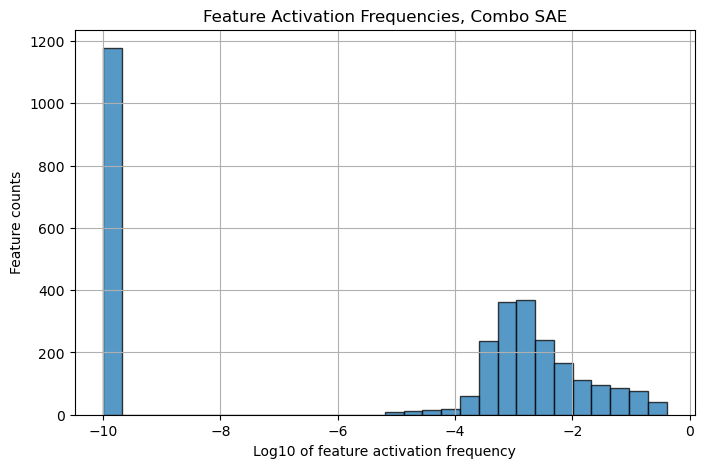

In [ ]:
# plot log10 of feature activation frequencies (also called feature density)
log_frequencies = np.log10(feature_frequencies + 1e-10)  # avoid log 0

plt.figure(figsize=(8, 5))
plt.hist(log_frequencies, bins=30, edgecolor="black", alpha=0.75)
plt.xlabel("Log10 of feature activation frequency")
plt.ylabel("Feature counts")
plt.title("Feature Activation Frequencies, Combo SAE")
plt.grid(True)
plt.show()
